In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
plt.rcParams['figure.figsize'] = [12, 8]

ImportError: cannot import name 'svm' from 'sklearn.linear_model' (/home/andrezasa/.local/lib/python3.8/site-packages/sklearn/linear_model/__init__.py)

In [50]:
def plot_graph(y_test, y_pred, title):
    plt.plot(y_test, label='y_true')
    plt.plot(y_pred, label='y_pred')
    plt.legend()
    plt.title(title)
    plt.ylabel("Gold Week Price")
    plt.show()

In [54]:
gold = pd.read_csv('ouro2.csv')
gold.columns = ['data', 'today_price']
gold = gold[::-1].reset_index(drop=True)
gold.head()

,data,today_price
0,18/06/2000,282.7
1,25/06/2000,290.1
2,02/07/2000,283.2
3,09/07/2000,281.1
4,16/07/2000,280.1


In [77]:
gold['data']= pd.to_datetime(gold.data, dayfirst=True) #transform data into datetime
gold['last_week_price'] = gold.today_price.shift(1)
gold['next_week_price'] = gold.today_price.shift(-1)
filtro = np.where(gold['next_week_price'] > gold['today_price'], 1, 0)
gold['target_subida'] = filtro

gold['delta'] = gold.today_price - gold.last_week_price
gold['m3'] = gold.today_price.rolling(window=3).mean().shift()
gold['m5'] = gold.today_price.rolling(window=5).mean().shift()
gold['m7'] = gold.today_price.rolling(window=7).mean().shift()
gold['m9'] = gold.today_price.rolling(window=9).mean().shift()
gold.dropna(inplace=True)
gold.head()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
27,2000-12-24,272.0,273.7,0,268.0,-1.7,272.100000,270.26,268.785714,267.833333
28,2000-12-31,268.0,272.0,0,263.9,-4.0,272.033333,271.40,269.857143,268.677778
29,2001-01-07,263.9,268.0,1,264.3,-4.1,271.233333,271.26,270.185714,269.055556
30,2001-01-14,264.3,263.9,0,262.8,0.4,267.966667,269.60,269.842857,268.988889
31,2001-01-21,262.8,264.3,1,267.1,-1.5,265.400000,268.38,269.214286,268.833333


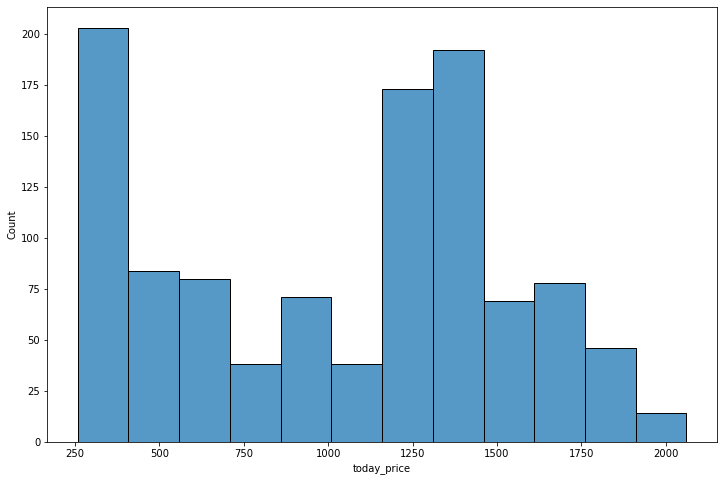

In [57]:
sns.histplot(gold.today_price)

### Normal series

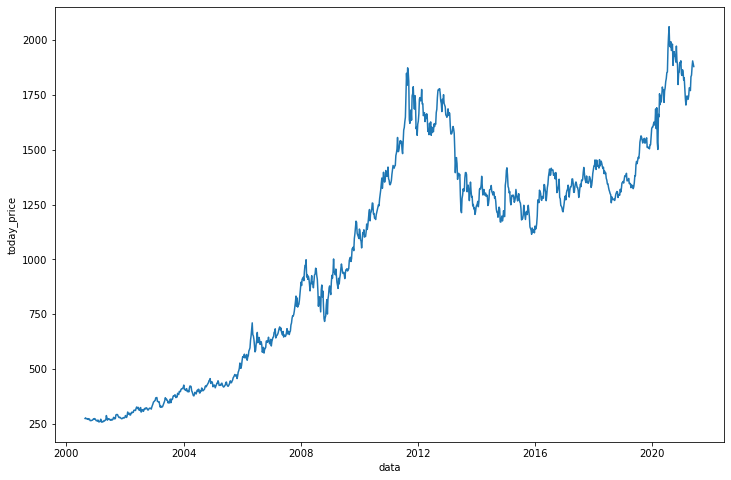

In [58]:
sns.lineplot(x=gold.data,y=gold.today_price)
# sns.lineplot(x=gold.data,y=gold.m7)
# sns.lineplot(x=gold.data,y=gold.m9)

In [59]:
gold.tail()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
1090,2021-05-09,1840.0,1833.5,1,1878.9,6.5,1794.400000,1782.44,1768.428571,1761.011111
1091,2021-05-16,1878.9,1840.0,1,1905.3,38.9,1814.433333,1801.08,1783.214286,1773.866667
1092,2021-05-23,1905.3,1878.9,1,1892.0,26.4,1850.800000,1820.42,1804.442857,1788.655556
1093,2021-05-30,1892.0,1905.3,0,1879.6,-13.3,1874.733333,1845.50,1827.085714,1807.411111
1094,2021-06-06,1879.6,1892.0,0,1868.0,-12.4,1892.066667,1869.94,1842.771429,1825.377778


# Primeiros Experimentos:

Treinamento utilizando como conjunto de treino os preços atuais (today_price)
e target (next_week_price)


**entra preço -> prediz preço**

In [60]:
X_test_numpy = gold['today_price'].tail(100).to_numpy()
y_test_numpy = gold['next_week_price'].tail(100).to_numpy()
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test_numpy.shape, y_test_numpy.shape))

Número de linhas: (100,)
Número de colunas: (100,)


In [61]:
X_train_numpy = gold['today_price'].head(-100).to_numpy()
y_train_numpy = gold['next_week_price'].head(-100).to_numpy()
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train_numpy.shape, y_train_numpy.shape))

Número de linhas: (986,)
Número de colunas: (986,)


In [62]:
X_train_numpy = X_train_numpy.reshape(-1, 1)
X_test_numpy = X_test_numpy.reshape(-1, 1)

### Regressão Linear


RMSE  1923.7162326535524


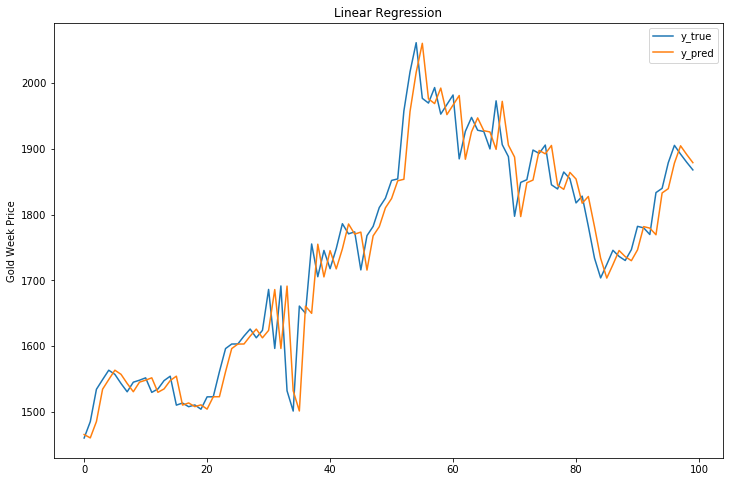

Acertos: 100


In [63]:
linear = LinearRegression().fit(X_train_numpy, y_train_numpy)
y_pred = linear.predict(X_test_numpy)
rmse = mean_squared_error(y_test_numpy, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test_numpy, y_pred, "Linear Regression")

predicted_price = linear.predict(X_test_numpy)
d = {'actual_price': y_test_numpy,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(-1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)

acertos = (df["correct_prediction"]==True).count()
print("Acertos: {}".format(acertos))

### Lasso

RMSE  1923.7162528255074


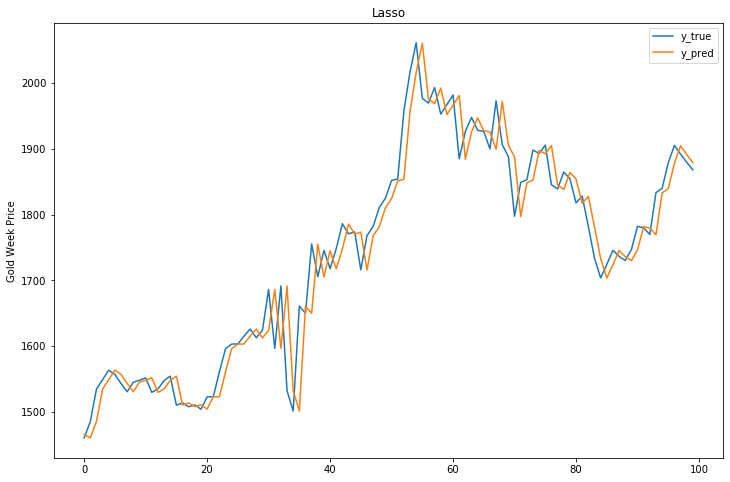

Acertos: 100


In [34]:
ridge = Ridge().fit(X_train_numpy, y_train_numpy)
y_pred = ridge.predict(X_test_numpy)
rmse = mean_squared_error(y_test_numpy, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test_numpy, y_pred, "Lasso")

predicted_price = linear.predict(X_test_numpy)
d = {'actual_price': y_test_numpy,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(-1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)

acertos = (df["correct_prediction"]==True).count()
print("Acertos: {}".format(acertos))

### Random Forest

RMSE  5769.487544498485


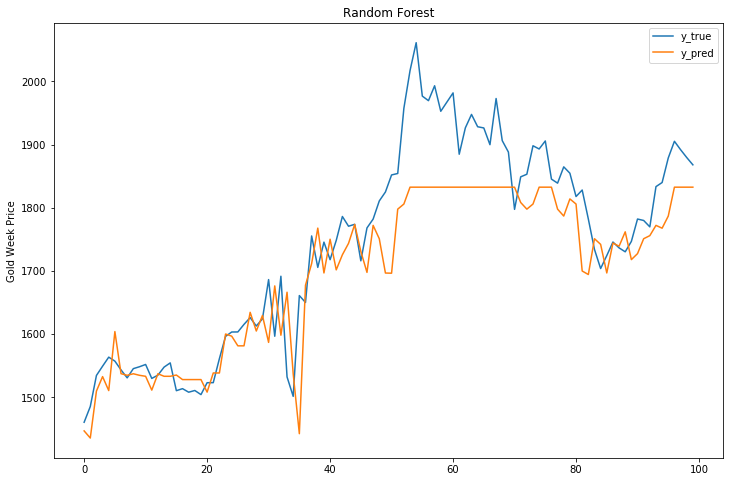

Acertos: 100


In [33]:
rf = RandomForestRegressor().fit(X_train_numpy, y_train_numpy)
y_pred = rf.predict(X_test_numpy)
rmse = mean_squared_error(y_test_numpy, y_pred, squared=True)
print("RMSE ", rmse)
plot_graph(y_test_numpy, y_pred, "Random Forest")

predicted_price = linear.predict(X_test_numpy)
d = {'actual_price': y_test_numpy,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(-1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(-1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)


acertos = (df["correct_prediction"]==True).count()
print("Acertos: {}".format(acertos))

In [25]:
res.shape

(49, 7)

# Segunda leva de Experimentos:

Agora utilizaremos outros valores como médias móveis e delta de uma semana pra outras

**entra preço hoje, preço semana passada e delta -> prediz se subira ou não**

In [45]:
from sklearn import tree

In [78]:
X_test_numpy = gold.filter(['delta', 'm3'],axis=1).tail(100).to_numpy()
y_test_numpy = gold['target_subida'].tail(100).to_numpy()
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test_numpy.shape, y_test_numpy.shape))

Número de linhas: (100, 2)
Número de colunas: (100,)


In [79]:
X_train_numpy = gold.filter(['delta', 'm3']).head(-100).to_numpy()
y_train_numpy = gold['target_subida'].head(-100).to_numpy()
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train_numpy.shape, y_train_numpy.shape))

Número de linhas: (966, 2)
Número de colunas: (966,)


In [80]:
clf = tree.DecisionTreeClassifier().fit(X_train_numpy, y_train_numpy)

[Text(272.9909175368551, 427.8658064516129, 'X[1] <= 1768.95\ngini = 0.493\nsamples = 966\nvalue = [426, 540]'),
 Text(270.3585833845209, 413.8374193548387, 'X[1] <= 913.733\ngini = 0.492\nsamples = 959\nvalue = [419, 540]'),
 Text(207.28538928132681, 399.8090322580645, 'X[1] <= 439.283\ngini = 0.476\nsamples = 417\nvalue = [163, 254]'),
 Text(168.28301443488945, 385.7806451612903, 'X[0] <= 13.35\ngini = 0.496\nsamples = 236\nvalue = [107, 129]'),
 Text(147.03796990171992, 371.7522580645161, 'X[1] <= 429.35\ngini = 0.493\nsamples = 227\nvalue = [100, 127]'),
 Text(125.60655405405407, 357.72387096774196, 'X[1] <= 421.217\ngini = 0.489\nsamples = 212\nvalue = [90, 122]'),
 Text(98.53772727272728, 343.69548387096773, 'X[1] <= 263.567\ngini = 0.494\nsamples = 195\nvalue = [87, 108]'),
 Text(83.1241769041769, 329.66709677419357, 'X[0] <= 3.7\ngini = 0.32\nsamples = 10\nvalue = [2, 8]'),
 Text(80.49184275184275, 315.63870967741934, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]'),
 Text(85.7565110

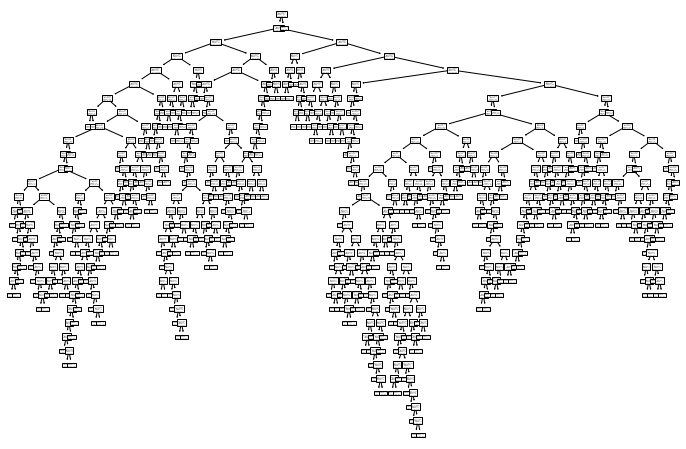

In [81]:
tree.plot_tree(clf) 

In [82]:
y_pred = clf.predict(X_test_numpy)

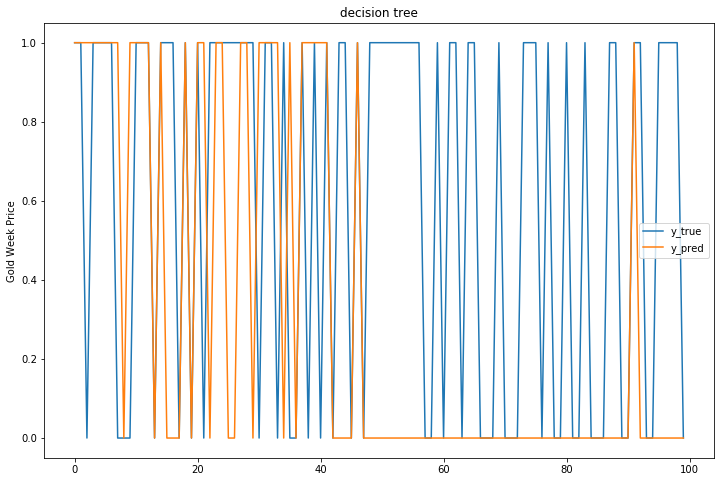

In [83]:
plot_graph(y_test_numpy, y_pred, "decision tree")

In [90]:
accuracy_score(y_test_numpy, y_pred)

0.54